In [0]:
from tensorflow.keras import models, layers, datasets
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import numpy as np

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [17]:
train_images = train_images[..., tf.newaxis]
test_images = test_images[..., tf.newaxis]
train_images.shape

(60000, 28, 28, 1)

In [0]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.add(layers.Softmax())

In [72]:
model.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=4, 
                    validation_data=(test_images, test_labels))

Epoch 1/4
1875/1875 [==============================] - 57s 31ms/step - loss: 1.6116 - accuracy: 0.8511 - val_loss: 1.5725 - val_accuracy: 0.8869
Epoch 2/4
1875/1875 [==============================] - 54s 29ms/step - loss: 1.5351 - accuracy: 0.9255 - val_loss: 1.4806 - val_accuracy: 0.9809
Epoch 3/4
1875/1875 [==============================] - 54s 29ms/step - loss: 1.4803 - accuracy: 0.9813 - val_loss: 1.4799 - val_accuracy: 0.9814
Epoch 4/4
1875/1875 [==============================] - 54s 29ms/step - loss: 1.4779 - accuracy: 0.9834 - val_loss: 1.4769 - val_accuracy: 0.9839


In [0]:
test_pred = model.predict(test_images)

In [76]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction=tf.keras.losses.Reduction.NONE)
loss_values = loss(test_labels,test_pred).numpy()
print(loss_values,len(loss_values))

[1.4611502 1.4611502 1.4611502 ... 1.4611502 1.461151  1.4611502] 10000


In [0]:
def plot_top_losses(actual, pred, k=9, figsize=(10,10)):
  loss_values = loss(actual,pred).numpy()
  top_k = loss_values.argsort()[-k:][::-1]
  cols = math.ceil(math.sqrt(k))
  rows = math.ceil(k/cols)
  fig,axes = plt.subplots(rows, cols, figsize=figsize)
  fig.suptitle('Prediction/Actual/Loss/Prediction_Probability', weight='bold', size=14)
  i =0
  for index in top_k:
    image = test_images[index]
    actual = test_labels[index]
    loss_value = loss_values[index]
    predicted = np.argmax(test_pred[index])
    prob = pred[index][predicted]
    title = f'{predicted}/{actual}/{loss_value:.2f}/{prob:.2f}'
    ax = axes.flat[i]
    i+=1
    image = np.squeeze(image,axis=2)
    ax.imshow(image)
    ax.set_title(title)

3


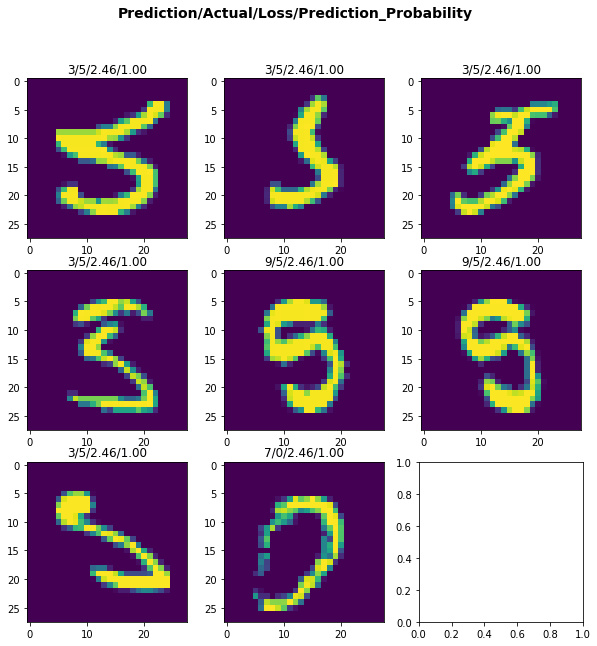

In [117]:
plot_top_losses(test_labels,test_pred,k=8)

## Callback function

In [0]:
class top_k_loss(tf.keras.callbacks.Callback):
  def __init__(self, k=3):
    self.k = k
    super(top_k_loss, self).__init__()
    self.top_loss = {}
  def on_epoch_end(self, epoch, logs=None):
    train_pred = self.model.predict(train_images)
    loss_values = self.model.loss(train_labels,train_pred).numpy()
    top_k = loss_values.argsort()[-self.k:][::-1]
    for index in top_k:
      actual_class = train_labels[index]
      loss_value = loss_values[index]
      predicted_class = np.argmax(train_pred[index])
      prob = train_pred[index][predicted_class]
      self.top_loss[epoch] = [predicted_class,actual_class,loss_value,prob,index]